# Retrieval with Known Answer (Plus Some Noise)

In this notebook (which is a near-copy of "injection_recovery"), we will set up a simulated TTV system, where the answer is known. We will add some noise to this data, and sample it randomly. We will then run `ttvnest` on the final simulated data and verify that we recover a good solution. First, we import necessary packages:

In [1]:
%matplotlib inline
import ttvnest
import numpy as np

Now we set up our simulation by running a forward model on a dummy `ttvnest` simulation. This is a two planet system in which both planets transit. Planet one has $$M_1/M_\star = 4\ M_\mathrm{Earth}/M_\mathrm{Sun}, P_1 = 10.0\ \mathrm{days}, e_1\cos\omega_1 = 0.02, e_1\sin\omega_1 = 0.01, T_{0,1} = 2.0\ \mathrm{days}.$$ Planet two has $$M_2/M_\star = 6\ M_\mathrm{Earth}/M_\mathrm{Sun}, P_2 = 15.2\ \mathrm{days}, e_2\cos\omega_2 = 0.025, e_2\sin\omega_2 = 0.015, T_{0,2} = 5.0\ \mathrm{days}.$$ By default, the planets are set to be coplanar. Notice that the system is close to a 3:2 mean-motion resonance, so that we get a nice-looking TTV curve. In this simple test, the data are homoskedastic with $\sigma = 2\times10^{-4}$ days = 0.288 min.

To make this a bit more interesting, we will perturb the exact transit timing solution with timing noise drawn from $\mathcal{N}(0, \sigma)$, and we will sample the data unevenly.

In [2]:
theta = [4., 10., 0.02, 0.01, 2., 6., 15.2, 0.025, 0.015, 5.]
perturbation_scale = 2e-4

#these are dummy arrays for the ttvs, errors, and observation epochs
planet_a = ttvnest.TTVPlanet([2., 12.], [1., 1.], [0, 1]) 
planet_b = ttvnest.TTVPlanet([5., 20.2], [1., 1.], [0, 1]) 
system = ttvnest.TTVSystem(planet_a, planet_b, sim_length = 1000)
data = system.forward_model(theta)

#perturbing the data with noise drawn from N(0, sigma)
perturbation = [np.random.normal(0., perturbation_scale, arr.shape) for arr in data]
data += perturbation
errs = [np.ones(arr.shape)*perturbation_scale for arr in data]
epochs = [np.arange(len(arr)) for arr in data]

#uneven sampling
for i in range(49):
    selection = np.random.randint(0, len(data[0]) - 1)
    data[0] = np.delete(data[0], selection)
    errs[0] = np.delete(errs[0], selection)
    epochs[0] = np.delete(epochs[0], selection)
    
for i in range(29):
    selection = np.random.randint(0, len(data[1]) - 1)
    data[1] = np.delete(data[1], selection)
    errs[1] = np.delete(errs[1], selection)
    epochs[1] = np.delete(epochs[1], selection)

print(data, epochs)

Simulation start/reference time:  0.0
ttvnest timestep:  0.04
Simulation length:  1000
Simulation end time:  1000.0
[array([  1.99995102,  12.00062488,  22.00032957, 102.00629919,
       122.00638969, 132.00655204, 152.00639878, 172.00610967,
       182.00624834, 232.0074367 , 242.00699863, 252.00756275,
       262.00924517, 292.0116545 , 322.01450551, 342.01503574,
       362.01821618, 382.02068901, 392.02140766, 402.02130227,
       462.02642986, 472.02702386, 492.02758299, 522.02764202,
       532.02757088, 572.02803448, 592.0278466 , 602.02816968,
       632.02876269, 642.0302529 , 652.02989072, 662.03062536,
       672.03261795, 692.03300286, 712.03559594, 722.0355524 ,
       752.03890483, 792.04461684, 802.04517016, 822.04725701,
       832.04720772, 842.04743709, 872.04821582, 892.04979563,
       912.04875885, 922.0495103 , 932.04903396, 952.04939565,
       972.04937274, 982.0494522 , 992.05006311])
 array([  5.00033658,  20.19874317,  50.59608035,  65.79450159,
        80.99

For our retrieval, we set up two ``TTVPlanet`` objects, initialized with arrays of transit timing data, errors, and observation epochs (where the first transit after the simulation start time MUST be epoch 0). We can also pretty reliably guess that the average periods are around 10 days and 15.2 days for the planets, so we update the period prior with that knowledge. We'll also assume (to make the run time a bit nicer), that someone has done some first-order TTV theory and shown that the masses are small, so we'll use a uniform prior between 0 and 10 earth masses (relative to the stellar mass) for both planets.

We then put these planets into a ``TTVSystem``, using now the external timekeeping system to fix the simulation start_time and sim_length (we're still letting the system internally choose dt):

In [3]:
planet_a = ttvnest.TTVPlanet(data[0], errs[0], epochs[0], mass_prior = ('Uniform', 0, 30.), 
                     period_prior = ('Normal', 10., 0.01))
planet_b = ttvnest.TTVPlanet(data[1], errs[1], epochs[1], mass_prior = ('Uniform', 0, 30.), 
                     period_prior = ('Normal', 15.2, 0.01))
system = ttvnest.TTVSystem(planet_a, planet_b, start_time = 0, sim_length = 1000)

Simulation start/reference time:  0
ttvnest timestep:  0.4
Simulation length:  1000
Simulation end time:  1000


Let's visualize how these TTV data look (when the best-fit period is detrended):

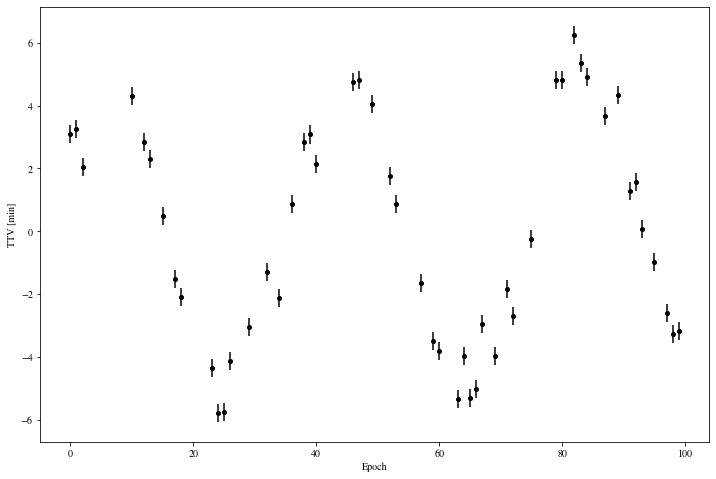

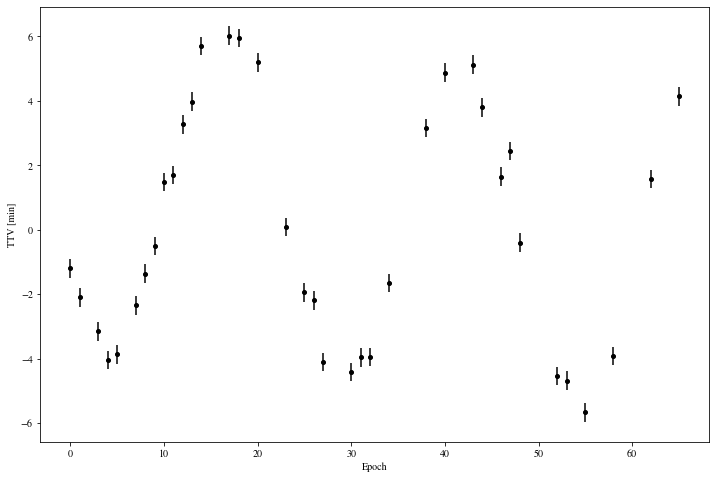

In [4]:
ttvnest.plot_utils.plot_ttv_data(system)

Looks more like real data. Still very visibly anticorrelated TTV signals as we would expect, with chopping thrown in for good measure.

Before we run our retrieval, let's check what the theoretical maximum for the log-likelihood is using our known solution:

In [5]:
print(system.log_likelihood(theta, system.data, system.errs, system.epochs))

623.0650504697026


Finally, let's run our retrieval! The ``retrieve`` function takes an argument ``retriever``. The default sampler I've chosen is the ``DynamicNestedSampler`` from ``dynesty``. I support the ``NestedSampler`` from that package as well, but have found the ``DynamicNestedSampler`` to do a better job at estimating the posterior for TTV retrieval problems (as it's designed to do with the right weight and stopping functions). If you pass in any supported keyword arguments for either of the supported nested samplers, the function will pass it on to ``dynesty`` (other non-recognized keyword arguments will be ignored).

In [6]:
results = system.retrieve()

13249it [08:02,  9.85it/s, batch: 0 | bound: 22 | nc: 25 | ncall: 177115 | eff(%):  7.438 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010] /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13592it [08:44,  7.21it/s, batch: 0 | bound: 25 | nc: 25 | ncall: 188006 | eff(%):  7.191 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]  /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
19056it [19:03,  8.45it/s, batch: 0 | bound: 66 | nc: 25 | ncall: 334683 | eff(%):  5.677 | loglstar:   -inf < -471965.265 <    inf | logz: -471991.912 +/-    nan | dlogz: 434984.303 

35882it [59:33,  7.03it/s, batch: 0 | bound: 204 | nc: 25 | ncall: 857593 | eff(%):  4.179 | loglstar:   -inf < -661.905 <    inf | logz: -703.868 +/-    nan | dlogz: 990.888 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
38509it [1:05:58,  7.17it/s, batch: 0 | bound: 224 | nc: 25 | ncall: 935217 | eff(%):  4.113 | loglstar:   -inf < -20.370 <    inf | logz: -64.528 +/-    nan | dlogz: 538.959 >  0.010]    /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-fact

44067it [1:29:06,  7.68it/s, batch: 0 | bound: 279 | nc: 25 | ncall: 1254033 | eff(%):  3.511 | loglstar:   -inf < 499.998 <    inf | logz: 452.434 +/-    nan | dlogz: 120.876 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
44649it [1:31:13,  8.89it/s, batch: 0 | bound: 284 | nc: 25 | ncall: 1285342 | eff(%):  3.471 | loglstar:   -inf < 520.009 <    inf | logz: 471.952 +/-    nan | dlogz: 100.774 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor 

49165it [2:01:06, 10.32it/s, batch: 0 | bound: 332 | nc: 25 | ncall: 1703134 | eff(%):  2.885 | loglstar:   -inf < 599.090 <    inf | logz: 547.934 +/-    nan | dlogz: 22.809 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
49728it [2:04:38,  8.03it/s, batch: 0 | bound: 337 | nc: 25 | ncall: 1748764 | eff(%):  2.842 | loglstar:   -inf < 603.074 <    inf | logz: 551.668 +/-    nan | dlogz: 18.510 >  0.010]   /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-facto

We finished with a best log-likelihood that's higher than the solution...makes sense because we added some noise. Let's get a summary of our results in $\LaTeX$-friendly format:

In [7]:
system.posterior_summary()

Summary (middle 95 percentile): 
$M_1/M_\star/3\times10^{-6}$: $3.851983^{+0.309951}_{-0.306639}$
$P_1\ [\mathrm{days}]$: $10.00003^{+8.9e-05}_{-8.7e-05}$
$\sqrt{e}_1\cos(\omega_1)$: $-0.023868^{+0.054442}_{-0.071627}$
$\sqrt{e}_1\sin(\omega_1)$: $-0.011107^{+0.061807}_{-0.077045}$
$T_{0,1}\ [\mathrm{days}]$: $1.999965^{+0.000142}_{-0.000132}$
$M_2/M_\star/3\times10^{-6}$: $5.813643^{+0.50473}_{-0.528073}$
$P_2\ [\mathrm{days}]$: $15.199948^{+0.000125}_{-0.000128}$
$\sqrt{e}_2\cos(\omega_2)$: $-0.013268^{+0.046234}_{-0.070228}$
$\sqrt{e}_2\sin(\omega_2)$: $-0.011016^{+0.059287}_{-0.06778}$
$T_{0,2}\ [\mathrm{days}]$: $4.999991^{+0.000111}_{-0.000111}$


The solution above is within the middle 95% of our retrieved posterior. Let's see how the best-fit solution and uncertainty look, for good measure:

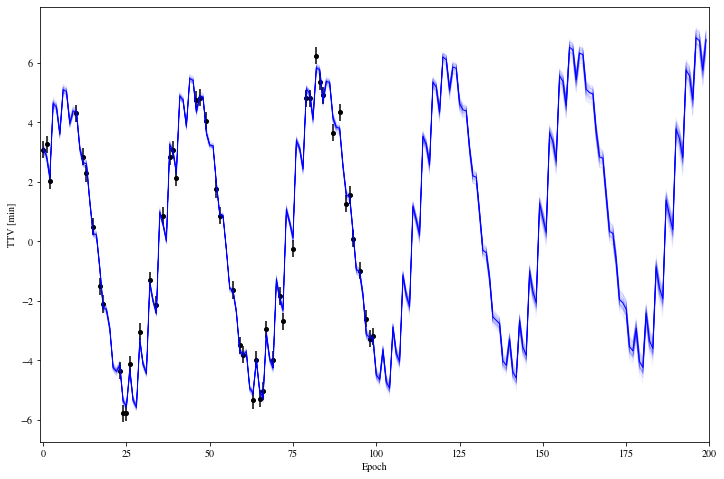

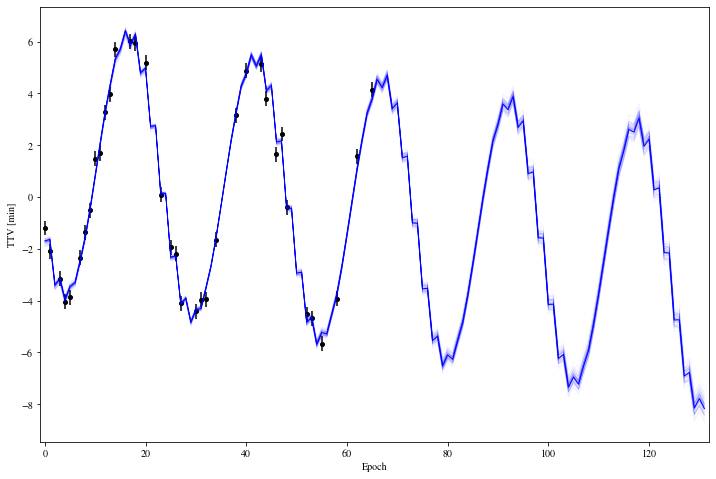

In [8]:
ttvnest.plot_utils.plot_results(system, uncertainty_curves = 100, sim_length = 2000)

With a hundred random draws from the posterior, it looks like we have a really solid constraint on the timing curve (even if the best solution we got isn't *exactly* the known answer). 

Finally, let's look at the corner plots (for viewing the marginalized posteriors) and trace plot (showing the evolution of all parameters over the run) from ``dynesty``:

<Figure size 1440x1440 with 0 Axes>

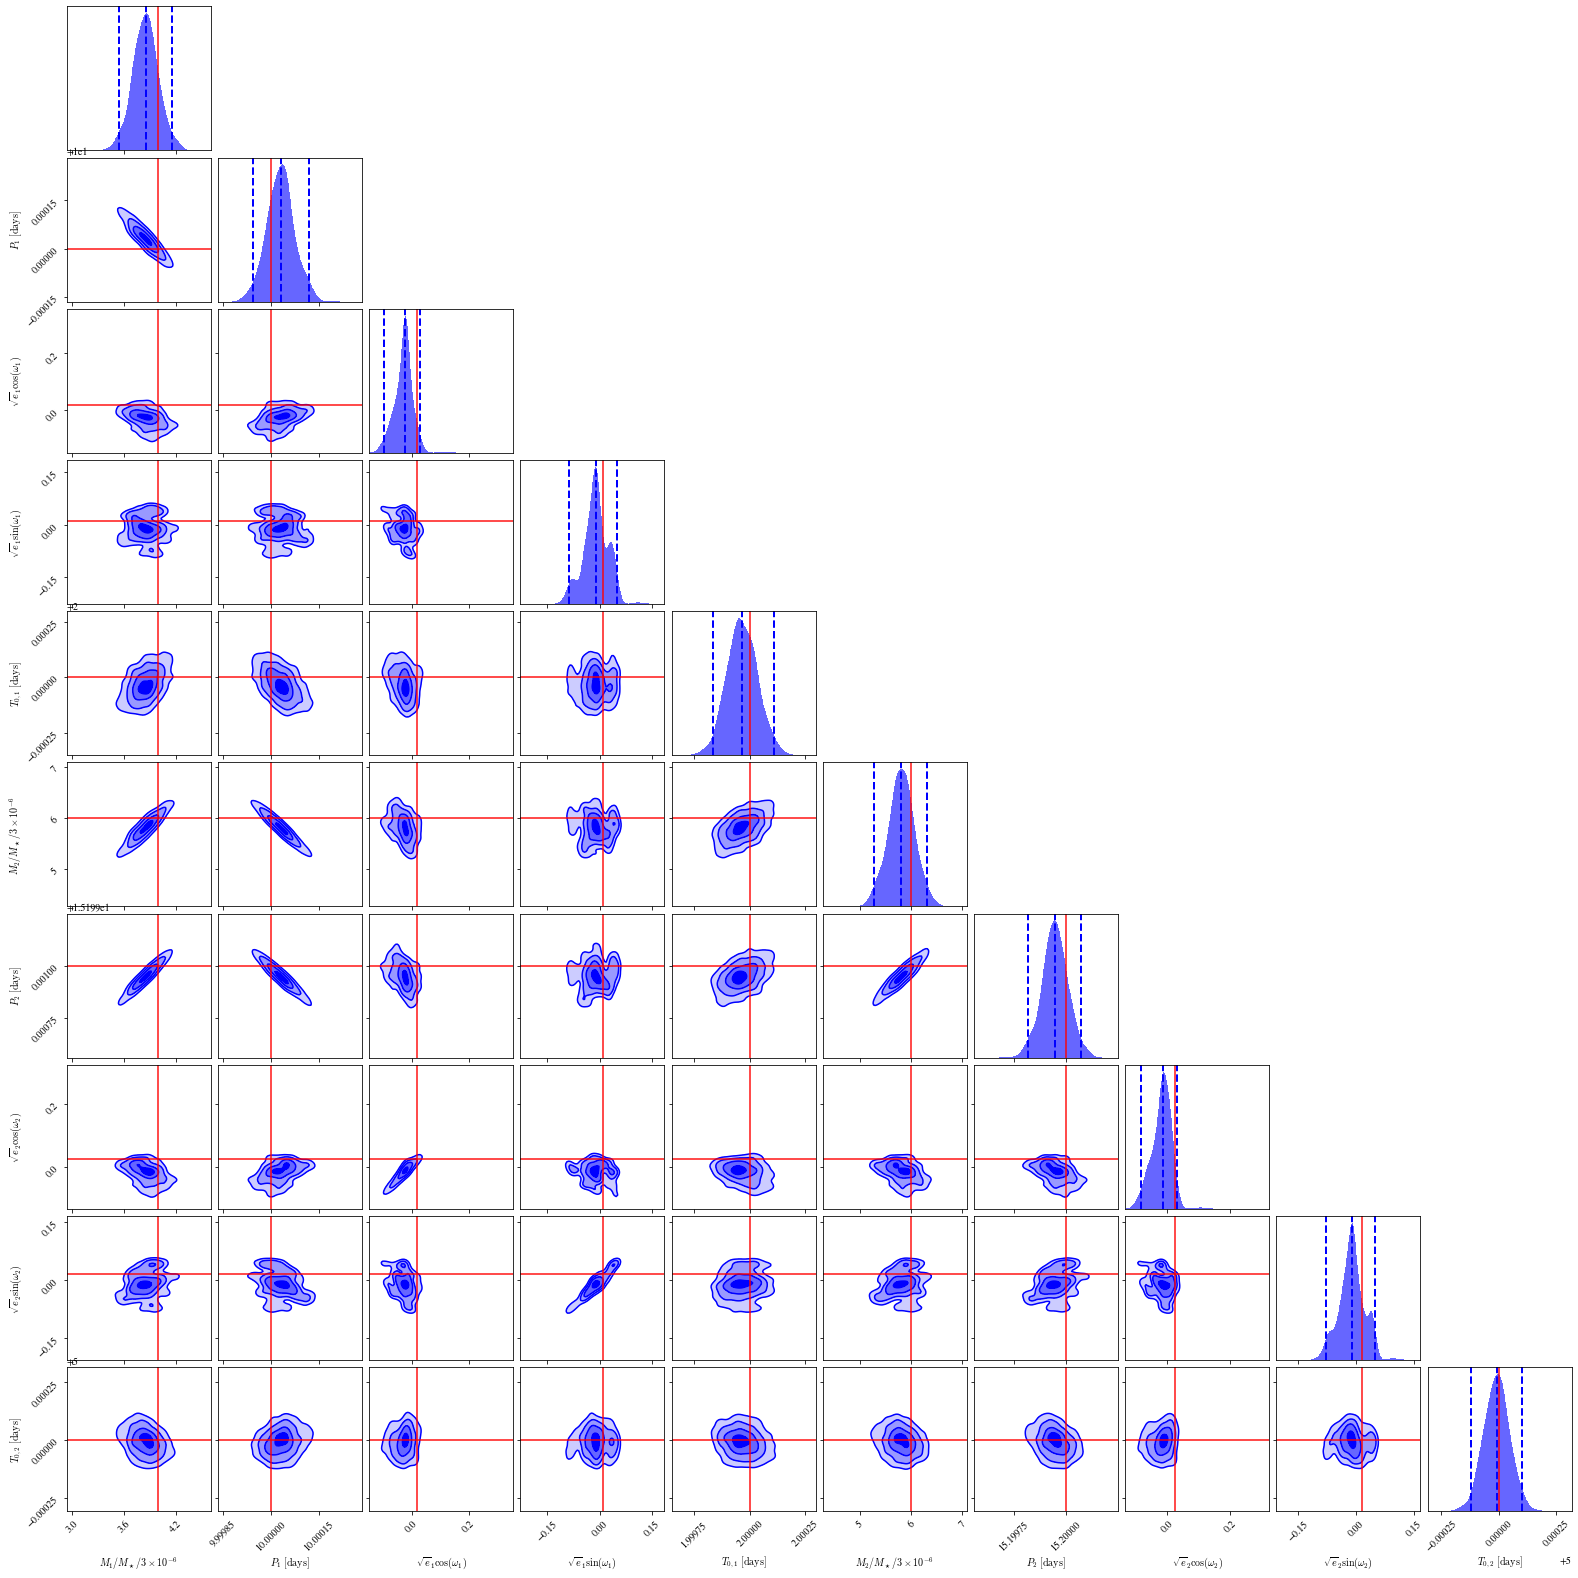

<Figure size 1440x1440 with 0 Axes>

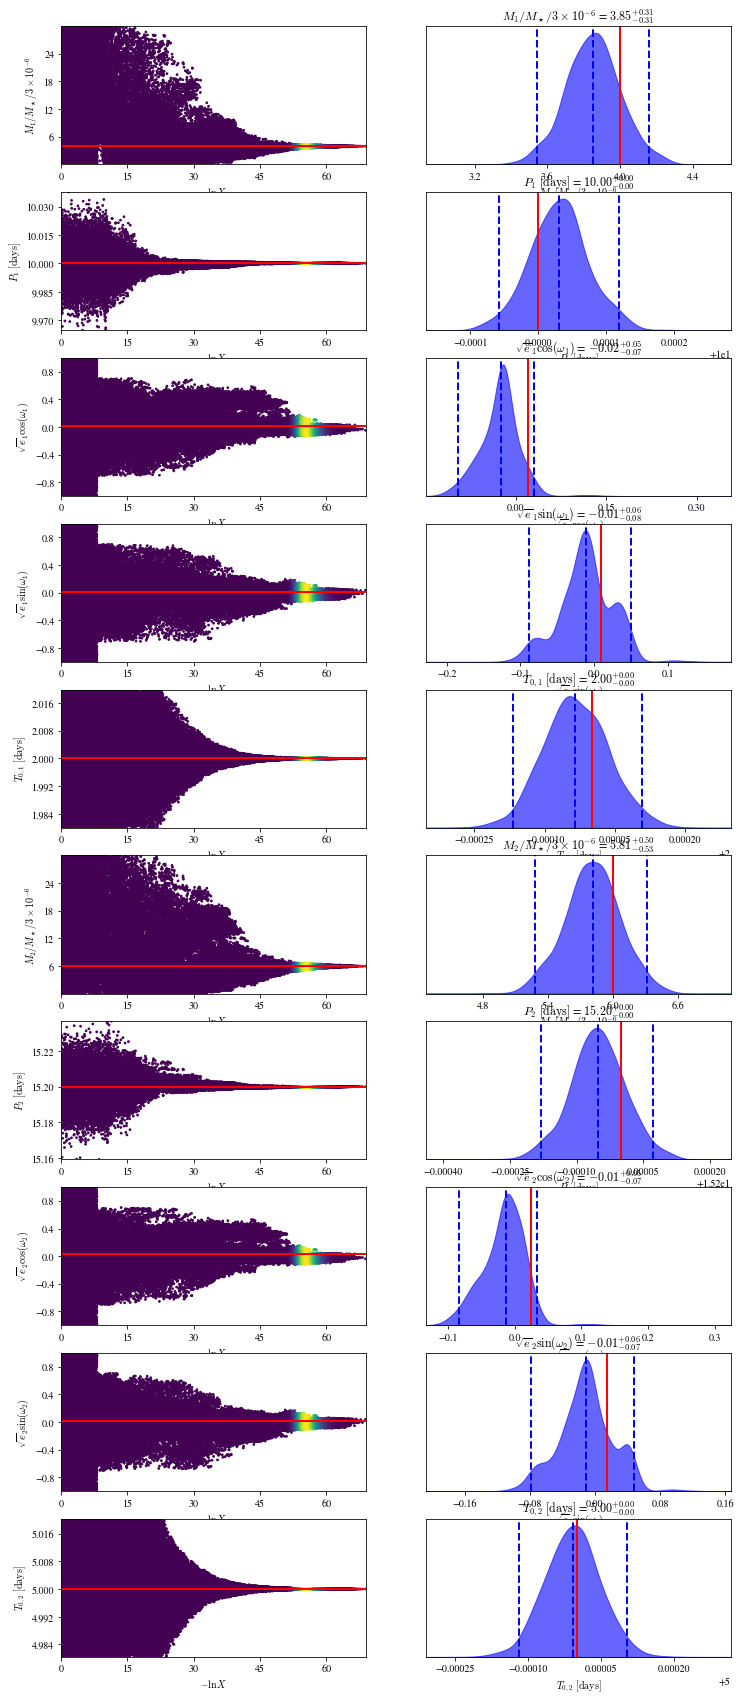

Axis limits error on runplot; internal to dynesty


/usr/local/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


In [9]:
ttvnest.plot_utils.dynesty_plots(system, truthvals = theta)

Pretty decent constraints, considering the noise and poor sampling!